# 순환신경망 intro 1

> 순환신경망 intro(1)- ab예제, embedding layer

# 강의영상
- https://youtube.com/playlist?list=PLQqh36zP38-zya4QF67x6DZfNtJRF-iPc

- https://guebin.github.io/DL2022/posts/IV.%20RNN/2022-11-01-9wk-2.html

# import

In [86]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Define some functions

`-` 활성화 함수들

In [87]:
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim = 1)
tanh = torch.nn.Tanh()

In [88]:
_x = torch.linspace(-5,5,100)

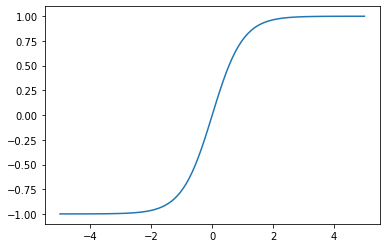

In [89]:
plt.plot(_x, tanh(_x)) # -1 ~ 1

`-` 문자열 $\to$ 숫자로 바꾸는 함수

In [90]:
def f(txt, mapping):
    return [mapping[key] for key in txt]

(사용예시1)

In [91]:
txt = ['a','b','a']
mapping = {'a':33, 'b':-22}
print('변환전: %s'%txt)
print('변환후: %s'%f(txt,mapping))

변환전: ['a', 'b', 'a']
변환후: [33, -22, 33]


(사용예시2)

In [92]:
txt = ['a','b','a']
mapping = {'a':[1,0], 'b':[0,1]}
print('변환전: %s'%txt)
print('변환후: %s'%f(txt, mapping))

변환전: ['a', 'b', 'a']
변환후: [[1, 0], [0, 1], [1, 0]]


# Exam1: ab

## data

In [93]:
txt = list('ab')*100
txt[:10]

['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']

In [94]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [95]:
txt_x[:5], txt_y[:5]

(['a', 'b', 'a', 'b', 'a'], ['b', 'a', 'b', 'a', 'b'])

x가 네트워크의 입력이라고 생각하고 b가 네트워크의 출력이라고 생각하면
- 네트워크 입력으로 a가 들어오면 b를 뱉어내고 
- 네트워크 입력으로 b가 들어오면 a를 뱉어낸다.

$\to$ 이러한 구조를 학습하면 된다.

## 선형모형을 이용한 풀이

### *(풀이1) 1개의 파라메터 - 실패*

In [96]:
mapping = {'a':0, 'b':1}
x = torch.tensor(f(txt_x, mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y, mapping)).float().reshape(-1,1)

In [97]:
x[:5], y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 학습 및 결과 시각화

In [98]:
net = torch.nn.Linear(in_features=1, out_features=1, bias=False)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [99]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizer.step()
    optimizer.zero_grad()

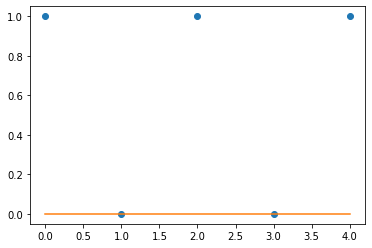

In [100]:
plt.plot(y[:5], 'o')
plt.plot(net(x).data[:5])

- 잘 학습이 안되었다.

`-` 학습이 잘 안된 이유

In [101]:
pd.DataFrame({'x':x[:5].reshape(-1), 'y':y[:5].reshape(-1)})

,x,y
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


현재 $\hat{y}_i = \hat{w}x_i$ 꼴의 아키텍처이고 $y_i \approx \hat{w}x_i$가 되는 적당한 $\hat{w}$를 찾아야 하는 상황
- $(x_i, y_i) = (0, 1)$ 이면 어떠한 $\hat{w}$ 를 선택해도 $y_i \approx \hat{w}x_i$ 를 만드는 것이 불가능
- $(x_i, y_i) = (1, 0)$ 이면 $\hat{w} = 0$ 일 경우 $y_i \approx \hat{w}x_i$로 만드는 것이 가능

상황을 종합해보니 $\hat{w}=0$으로 학습되는 것이 그나마 최선

### *(풀이2) 1개의 파라메터 - 성공, but 확장성이 없는 풀이*

`-` 0이라는 값이 문제가 되므로 인코딩방식의 변경

In [102]:
x = torch.tensor(f(txt_x, {'a':-1,'b':1})).float().reshape(-1,1)
y = torch.tensor(f(txt_y, {'a':-1,'b':1})).float().reshape(-1,1)

In [103]:
x[:5],y[:5]

(tensor([[-1.],
         [ 1.],
         [-1.],
         [ 1.],
         [-1.]]),
 tensor([[ 1.],
         [-1.],
         [ 1.],
         [-1.],
         [ 1.]]))

In [104]:
net = torch.nn.Linear(in_features=1, out_features=1, bias=False)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [105]:
for epoc in range(2000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

`-` 결과는 성공

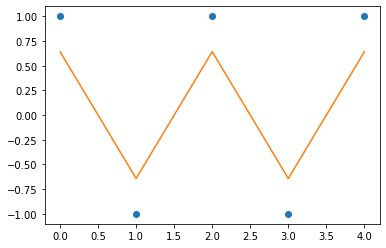

In [106]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])

딱봐도 클래스가 3개일 경우 확장이 어려워 보인다.

## 로지스틱 모형을 이용한 풀이

### *(풀이1) 1개의 파라메터 - 실패*

`-` 데이터를 다시 a=0, b=1로 정의

In [107]:
mapping = {'a':0, 'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [108]:
x[:5], y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-`  학습

In [109]:
net = torch.nn.Linear(in_features = 1, out_features = 1, bias = False)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

In [110]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

`-` 결과

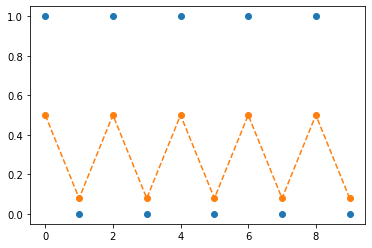

In [111]:
plt.plot(y[:10], 'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 결과해석: 예상되었던 실패임

- 아키텍처는 $\hat{y}_i = \text{sig}(\hat{w}x_i)$ 꼴이다.
- $(x_i, y_i) = (0,1)$ 이라면 어떠한 $\hat{w}$ 를 선택해도 $\hat{w}x_i=0$이다. 이 경우 $\hat{y}_i = sig(0) = 0.5$ 가 된다.
- $(x_i, y_i) = (1,0)$ 이라면 $\hat{w} = -5$와 같은 값으로 선택하면 $sig(-5)\approx - = y_i$와 같이 만들 수 있다.
- 상황을 종합해보면 net이 weight는 $sig(\hat{w}x_i)\approx 0$이 되도록 적당한 음수로 학습되는 것이 최선임을 알 수 있다.

In [112]:
net.weight # 적당한 음수값으로 학습되어있음을 확인

Parameter containing:
tensor([[-2.4571]], requires_grad=True)

### *(풀이2) 2개의 파라메터 + 좋은 초기값 - 성공*

2개의 파라메터를 쓴다는 것은 weight와 bias를 쓴다는 것.

`-` 동일하게 a=0,b=1로 맵핑

In [113]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [114]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 네트워크에서 bias를 넣기로 결정함

In [115]:
net = torch.nn.Linear(in_features=1, out_features=1, bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` net의 초기값을 설정 (이것은 좋은 초기값임)

$y = sig(-5x + 2.5)$

- $x=0 \to sig(2.5) \to y\text{는 1근처}$

- $x=1 \to sig(-2.5) \to y\text{는 0근처}$

*(참고)* $sig(x) = \frac{1}{1+e^{-x}}$

In [139]:
import numpy as np
1/(1+np.exp(-2.5)) , 1/(1+np.exp(2.5))

(0.9241418199787566, 0.07585818002124355)

In [116]:
net.weight.data = torch.tensor([[-5.00]])
net.bias.data = torch.tensor([+2.500])

In [117]:
net(x)[:10]

tensor([[ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000]], grad_fn=<SliceBackward0>)

`-` 학습 전 결과

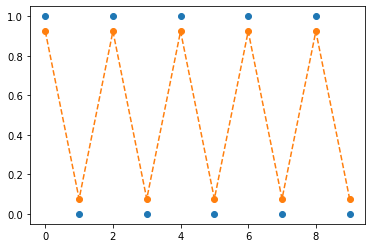

In [118]:
plt.plot(y[:10], 'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습 후 결과

In [119]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

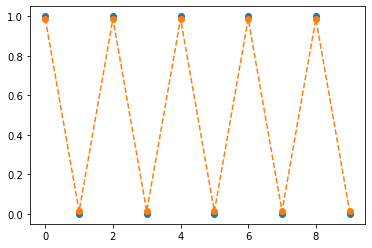

In [120]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

### *(풀이3) 2개의 파라메터 + 나쁜 초기값  - 성공*

`-` a=0,b=1

In [121]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [122]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 이전과 동일하게 바이어스가 포함된 네트워크 설정

In [123]:
net = torch.nn.Linear(in_features=1, out_features=1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` 초기값 설정 (이 초기값은 나쁜 초기값임)

In [124]:
net.weight.data = torch.tensor([[+5.00]])
net.bias.data = torch.tensor([-2.500])

In [125]:
net(x)[:10]

tensor([[-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000]], grad_fn=<SliceBackward0>)

`-` 학습전상태: 반대모양으로 되어있다.

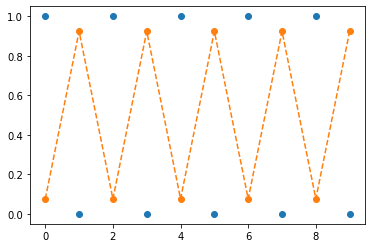

In [126]:
plt.plot(y[:10], 'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습

In [127]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

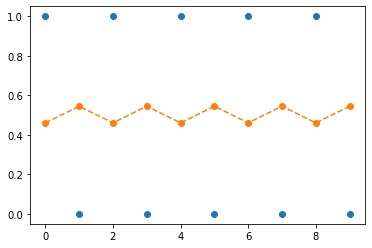

In [128]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

- 될 것 같긴한데 느릴것 같다..결국 수렴하긴 할듯. 

### *(풀이4) 3개의 파라메터를 쓴다면?*

`-` a=0, b=1로 코딩

In [129]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [130]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 3개의 파라메터를 사용하기 위해서 아래와 같은 구조를 생각하자.

```python
## 파라메터 3개를 줄 수 있는 방법
torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1, bias=True),  ## 파라메터 2개
    torch.nn.ACTIVATION_FUNCTION(),   ## activation 걸기  ## 파라메터 0개
    torch.nn.Linear(in_features=1, out_features=1, bias=False) ## 파라메터 1개
)
```

위와 같은 네트워크를 설정하면 3개의 파라메터를 사용할 수 있다. 적절한 ACTIVATION_FUNCTION을 골라야하는데 실험적으로 tanh가 적절하다고 알려져있다. ($\to$ 그래서 우리도 실험적으로 이해해보자.)

순환신경망에서 activation으로 tanh를 많이 사용한다. 이를 증명하기 위해서 실험을 해보자.

In [148]:
torch.nn.Sequential(
    torch.nn.Linear(in_features = 1, out_features = 1, bias = True),  ## 2개
    torch.nn.ReLU(), ## 0개 
    torch.nn.Linear(in_features = 1, out_features = 1, bias = False) ## 1개
)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=False)
)

---

(예비학습1) `net(x)`와 사실 `net.forward(x)`는 같다.

In [144]:
net(x)[:5] # 풀이3에서 학습한 네트워크임

tensor([[-0.1584],
        [ 0.1797],
        [-0.1584],
        [ 0.1797],
        [-0.1584]], grad_fn=<SliceBackward0>)

In [143]:
net.forward(x)[:5] # 풀이3에서 학습한 네트워크임

tensor([[-0.1584],
        [ 0.1797],
        [-0.1584],
        [ 0.1797],
        [-0.1584]], grad_fn=<SliceBackward0>)

그래서 net.forward를 재정의하면 net(x)의 기능을 재정의 할 수 있다.

In [149]:
net.forward = lambda x: 1

- "lambda x:1"은 입력이 x, 출력이 1인 함수를 의미한다. (즉, 입력값에 상관없이 항상 1을 출력하는 함수)
- "net.forward = lambda x:1"이라고 새롭게 선언하였으므로 앞으로는 net.forward(), net(x)도 입력값에 상관없이 항상 1을 출력하게 될 것임.

In [151]:
net(x)

1

(예비학습2) torch.nn.Module을 상속받아서 네트워크를 만들면 (='classXXX(torch.nn.Module):"와 같은 방식으로 클래스를 선언하면) 약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있다.

(예시1)

In [160]:
## 클래스는 인스턴스를 만드는 틀같은 걸로 생각.

In [184]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

In [185]:
net = Mynet1()

는 아래와 같은 효과를 가진다.

In [186]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=1, out_features=1, bias=False)
)

(예시2)

In [187]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1, out_features=1, bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=1, out_features=1, bias=False)
    def forward(self, x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

In [188]:
net = Mynet2()

는 아래와 같은 효과를 가진다.

In [189]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1, out_features=1, bias=False)
)

(예시3)

In [190]:
class Mynet3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1, out_features=1, bias=True)
        self.a1 = torch.nn.Tanh()
        self.l2 = torch.nn.Linear(in_features=1, out_features=1, bias=False)
    def forward(self, x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

In [191]:
net = Mynet3()

는 아래와 같은 효과를 가진다.

In [192]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1, bias=True),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1, out_features=1, bias=False)
)

#### <font color='red'>클래스에 대한 이해가 부족한 학생을 위한 암기방법</font>

**step1**: 아래의 코드를 복사하여 틀을 만든다. (무조건 고정임, XXXX자리는 원하는 이름을 넣는다.)

In [193]:
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 사용할 레이어를 정의
        
        ## 레이어 정의 끝
    def forward(self, x):
        ## yhat을 어떻게 구할것인지 정의
        
        ## 정의 끝
        return yhat

- net(x)에 사용하는 x임, yhat은 net.forward(x)의 리턴값임.
- 사실, x,yhat은 다른 변수로 써도 무방하나 (예를들어 input/output 이라든지) 설명의 편의상 x와 yhat을 고정한다.

**stpe2**: `def __init__(self)`에 사용할 레이어를 정의하고 이름을 붙인다. 이름은 항상 `self.xxx`와 같은 식으로 정의한다.

In [194]:
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Tanh()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 레이어 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat

**step3**: `def forward:`에 "x->yhat"으로 가는 과정을묘사한 코드를 작성하고 yhat을 리턴하도록 한다.

In [195]:
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Tanh()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 레이어 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        u = self.xxx1(x)
        v = self.xxx2(u)
        yhat = self.xxx3(v)
        ## 정의 끝
        return yhat

예비학습 끝

----

`-` 우리가 하려고 했던 것 : 아래의 아키텍처에서

```python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1, bias=True),
    torch.nn.ACTIVATION_FUNCTION(),
    torch.nn.Linear(in_features=1, out_features=1, bias=False)
)
```

ACTIVATION의 자리에 tanh가 왜 적절한지 직관을 얻어보자.

#### `-` 실험결과1(Sig): Sigmoid activation을 포함한 아키텍처로 학습시킨 25개의 적합결과

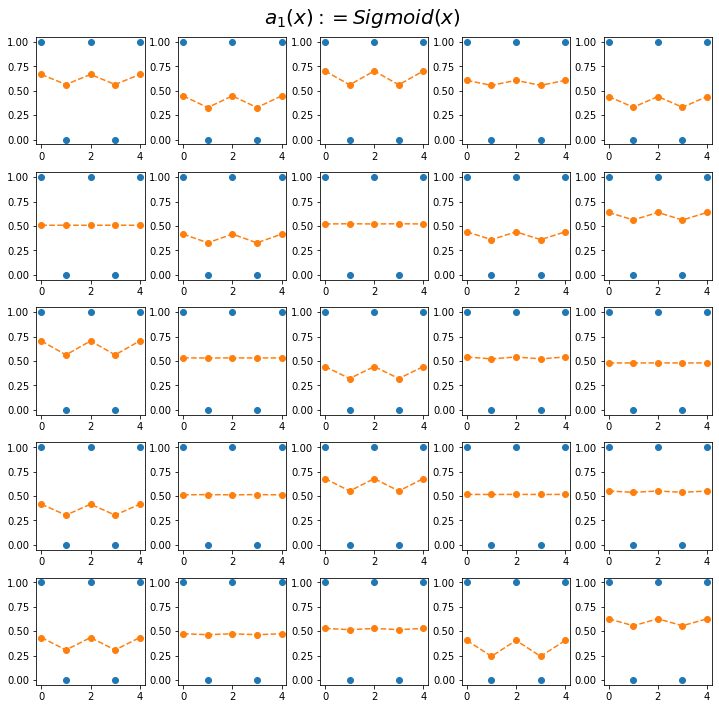

In [196]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet1()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            ## 1
            yhat = net(x)
            ## 2
            loss = loss_fn(yhat,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_1(x):=Sigmoid(x)$",size=20)
fig.tight_layout()

#### `-` 실험결과2(ReLU): ReLU activation을 포함한 아키텍처로 학습시킨 25개의 적합결과

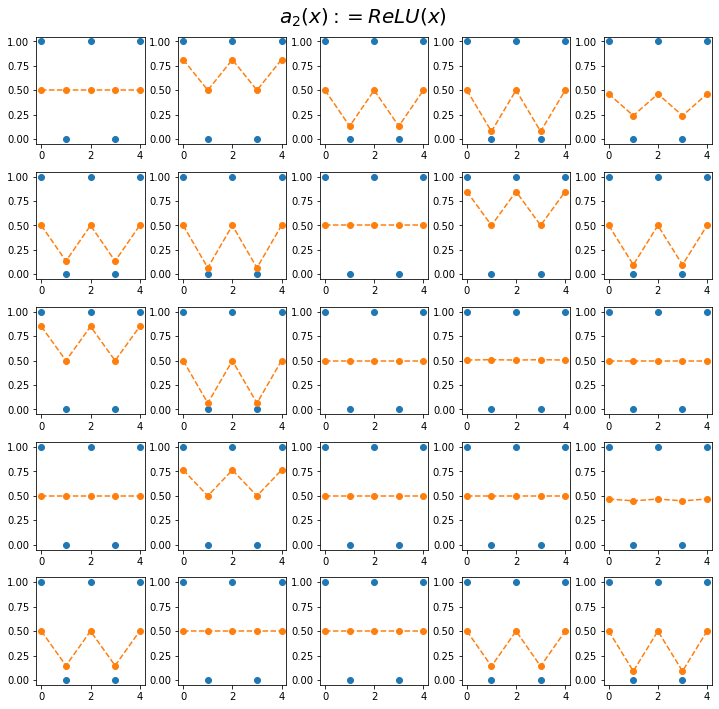

In [197]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet2()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            ## 1
            yhat = net(x)
            ## 2
            loss = loss_fn(yhat,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=ReLU(x)$",size=20)
fig.tight_layout()

#### `-` 실험결과3(Tanh): Tanh activation을 포함한 아키텍처로 학습시킨 25개의 적합결과

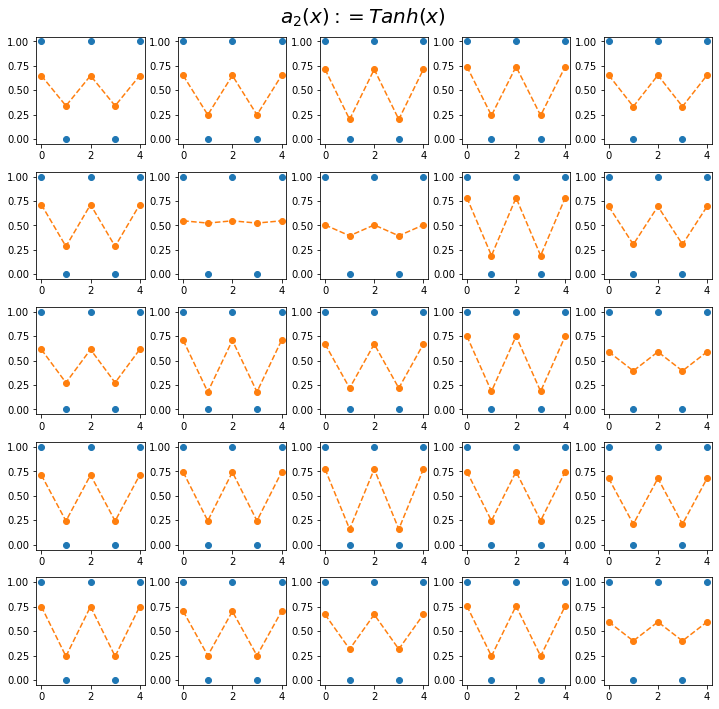

In [198]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet3()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            ## 1
            yhat = net(x)
            ## 2
            loss = loss_fn(yhat,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=Tanh(x)$",size=20)        
fig.tight_layout()

#### `-` 실험해석

- Sig: 주항색선의 변동폭이 작음 + 항상 $0.5$ 근처로 머무는 적합값이 존재
- ReLU: 주황색선의 변동폭이 큼 + 항상 $0.5$ 근처로 머무는 적합값이 존재
- Tanh: 주황색선의 변동폭이 큼 + $0.5$ 근처로 머무는 적합값이 존재X

실험해보니까 Tanh가 우수한 것 같다. $\to$ 앞으로는 Tanh를 쓰자.

## 소프트맥스로 확장

### (풀이1) 로지스틱모형에서 3개의 파라메터 버전을 그대로 확장

In [223]:
mapping = {'a':[1,0], 'b':[0,1]}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,2)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,2)
x[:5], y[:5]

(tensor([[1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.]]),
 tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]]))

- [1, 0] -> a
- [0, 1] -> b

In [204]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=1), # x의 shape이 2 -> in_features=2
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1, out_features=2, bias=False) # y의 shape이 2 -> out_features=2
)    
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [205]:
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [225]:
y[:5][:,1]

tensor([1., 0., 1., 0., 1.])

In [226]:
soft(net(x))[:5][:,1]

tensor([0.9952, 0.0049, 0.9952, 0.0049, 0.9952], grad_fn=<SelectBackward0>)

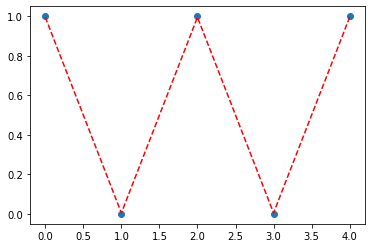

In [210]:
plt.plot(y[:5][:,1],'o') ## y
plt.plot(soft(net(x[:5]))[:,1].data,'--r') ## 예측한 값.

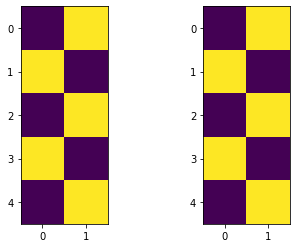

In [211]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y[:5])
ax[1].imshow(soft(net(x[:5])).data)

모양이 똑같이 나왔으니까 예측이 잘 되었다고 판단.

# Embedding Layer
> onehot encoding + Linear transform

### motive

`-` 결국 최종적으로는 아래와 같은 맵핑방식이 확장성이 있어보인다.

In [212]:
mapping = {'a':[1,0,0], 'b':[0,1,0], 'c':[0,0,1]} # 원핫인코딩 방식

`-` 그런데 매번 $\bf{X}$를 원핫인코딩하고 Linear 변환하는 것이 번거로운데 이를 한번에 구현하는 함수가 있었으면 좋겠다. $\to$ **torch.nn.Embedding Layer**가 그 역할을 한다.

In [213]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(list('abc')*100, mapping))
y = torch.tensor(f(list('bac')*100, mapping))
x[:5], y[:5]

(tensor([0, 1, 2, 0, 1]), tensor([1, 0, 2, 1, 0]))

In [214]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(num_embeddings=3, embedding_dim=1)

In [215]:
ebdd(x)[:5]

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052]], grad_fn=<SliceBackward0>)

`-` 그런데 사실 언뜻보면 아래의 linr함수와 역할의 차이가 없어보인다.

In [216]:
torch.manual_seed(43052)
linr = torch.nn.Linear(in_features=1, out_features=1)

In [217]:
linr(x.float().reshape(-1,1))[:5]

tensor([[-0.8470],
        [-1.1937],
        [-1.5404],
        [-0.8470],
        [-1.1937]], grad_fn=<SliceBackward0>)

`-` 차이점: 파라메터 수에 차이가 있다.

In [218]:
ebdd.weight

Parameter containing:
tensor([[-0.8178],
        [-0.7052],
        [-0.5843]], requires_grad=True)

In [219]:
linr.weight, linr.bias

(Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

결국 ebdd는 아래의 구조에 해당하는 파라메터들이고

- $\text{x[:5]}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} \quad net(x)= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052 \end{bmatrix}$

linr는 아래의 구조에 해당하는 파라메터이다.

$\text{x[:5]}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \quad net(x)= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

### 연습 (ab문제 소프트맥스로 확장한 것 다시 풀이)

`-` 맵핑

In [228]:
mapping = {'a':0, 'b':1}
x = torch.tensor(f(txt_x, mapping))
y = torch.tensor(f(txt_y, mapping))
x[:5], y[:5]

(tensor([0, 1, 0, 1, 0]), tensor([1, 0, 1, 0, 1]))

`-` torch.nn.Embedding을 넣은 네트워크

In [229]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=2, embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1, out_features=2)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [230]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

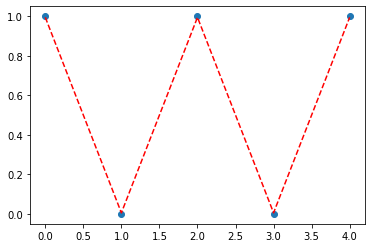

In [232]:
plt.plot(y[:5], 'o')
plt.plot(soft(net(x[:5]))[:,1].data,'--r')

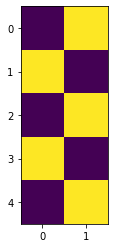

In [233]:
plt.imshow(soft(net(x[:5])).data)

# HW

아래의 코드를 관찰하라.

In [234]:
x = [0,1]*5
y = [1,0]*5
torch.manual_seed(43052) # 편의상 시드를 고정 
ebdd = torch.nn.Embedding(num_embeddings=2,embedding_dim=1)

In [235]:
ebdd.weight

Parameter containing:
tensor([[-0.8178],
        [-0.7052]], requires_grad=True)

ebdd(x)를 출력결과를 예측하여 작성하라.

(풀이)

굳이 실행해보지 않아도 아래임을 알 수 있다.

$\text{x}= \begin{bmatrix} 0 \\ 1 \\ 0 \\ 1 \\ 0 \\ 1 \\ 0 \\ 1 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \end{bmatrix} \quad net(x)= \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} -0.8178 \\ -0.7052 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.8178 \\ -0.7052 \\-0.8178 \\ -0.7052 \\-0.8178 \\ -0.7052 \\-0.8178 \\ -0.7052 \end{bmatrix}$

실행해보면서 확인

In [236]:
x = torch.tensor(x) # ebdd에 넣기위해 x를 텐서로 변환
x

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [237]:
ebdd(x)

tensor([[-0.8178],
        [-0.7052],
        [-0.8178],
        [-0.7052],
        [-0.8178],
        [-0.7052],
        [-0.8178],
        [-0.7052],
        [-0.8178],
        [-0.7052]], grad_fn=<EmbeddingBackward0>)